In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

In [2]:
DATA_DIR = "./data"
NEUTRAL_LEVEL = 50  # COT neutral

def list_futures(data_dir=DATA_DIR):
    csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
    futures = []
    for path in csv_files:
        base = os.path.basename(path)
        if "results" in base.lower() or "optimal" in base.lower():
            continue
        futures.append((os.path.splitext(base)[0], path))
    return futures

def load_future(path):
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]

    rename_map = {
        "time": "Time",
        "open": "Open",
        "high": "High",
        "low": "Low",
        "close": "Close",
        "Commercials Index": "CommIndex",
        "Large Speculators Index": "LargeIndex",
        "Small Speculators Index": "SmallIndex",
    }
    df = df.rename(columns=rename_map)

    df["Time"] = pd.to_datetime(df["Time"])
    df = df.sort_values("Time").reset_index(drop=True)

    return df[["Time", "Open", "High", "Low", "Close", "CommIndex", "LargeIndex", "SmallIndex"]]


In [3]:
def is_bullish_reversal(r):
    return (
        r["Low"] < r["Open"] and 
        r["Close"] > r["Open"] and
        r["Close"] > r["Open"] + 0.6*(r["High"] - r["Open"])
    )

def is_bearish_reversal(r):
    return (
        r["High"] > r["Open"] and 
        r["Close"] < r["Open"] and
        r["Close"] < r["Open"] - 0.6*(r["Open"] - r["Low"])
    )

def add_reversal_flags(df):
    df["BullRev"] = df.apply(is_bullish_reversal, axis=1)
    df["BearRev"] = df.apply(is_bearish_reversal, axis=1)
    return df


In [4]:
def run_strategy(df, X, Y, Z, A, B, C, contract_size=1.0):
    position = 0
    entry_price = None
    entry_time = None
    trades = []

    for idx, row in df.iterrows():
        comm = row["CommIndex"]
        large = row["LargeIndex"]
        small = row["SmallIndex"]
        price = row["Close"]

        # ===== EXIT =====
        if position == 1 and comm <= NEUTRAL_LEVEL:
            pnl = contract_size * (price - entry_price)
            trades.append({"EntryTime": entry_time, "ExitTime": row["Time"], "Dir": "LONG",
                           "EntryPrice": entry_price, "ExitPrice": price, "PnL": pnl})
            position = 0
            entry_price = None

        elif position == -1 and comm >= NEUTRAL_LEVEL:
            pnl = contract_size * (entry_price - price)
            trades.append({"EntryTime": entry_time, "ExitTime": row["Time"], "Dir": "SHORT",
                           "EntryPrice": entry_price, "ExitPrice": price, "PnL": pnl})
            position = 0
            entry_price = None

        # ===== ENTRY =====
        if position == 0:

            # Long entry
            if (
                row["BullRev"] and
                comm > X and
                large < Y and
                small < Z
            ):
                position = 1
                entry_price = price
                entry_time = row["Time"]

            # Short entry
            elif (
                row["BearRev"] and
                comm < A and
                large > B and
                small > C
            ):
                position = -1
                entry_price = price
                entry_time = row["Time"]

    # ===== METRICS =====
    pnls = np.array([t["PnL"] for t in trades], dtype=float)
    if len(pnls) == 0:
        return trades, {"Total": 0, "PF": 1, "Sharpe": 0, "NumTrades": 0}

    total = pnls.sum()
    wins = pnls[pnls > 0].sum()
    losses = -pnls[pnls < 0].sum()
    pf = (wins + 1e-9) / (losses + 1e-9)
    sharpe = pnls.mean() / (pnls.std() + 1e-9)

    return trades, {
        "Total": total,
        "PF": pf,
        "Sharpe": sharpe,
        "NumTrades": len(trades)
    }


In [5]:
def optimize_future(df, future_name):

    long_comm_vals  = [85, 90, 95]      # X
    long_spec_caps  = [5, 10]       # Y,Z

    short_comm_vals = [5, 10]       # A
    short_spec_floors = [90, 95]    # B,C

    best = None
    best_key = (-999, -999, -999)  # Sharpe, PF, Total

    for X, Y, Z, A, B, C in product(
        long_comm_vals,
        long_spec_caps,
        long_spec_caps,
        short_comm_vals,
        short_spec_floors,
        short_spec_floors,
    ):
        trades, metrics = run_strategy(df, X, Y, Z, A, B, C)
        key = (metrics["Sharpe"], metrics["PF"], metrics["Total"])

        if key > best_key:
            best_key = key
            best = {
                "Future": future_name,
                "X": X, "Y": Y, "Z": Z,
                "A": A, "B": B, "C": C,
                **metrics
            }

    return best


In [6]:
all_futures = list_futures()
results = []

for future_name, path in all_futures:
    print(f"Optimizing {future_name}...")
    df = load_future(path)
    df = add_reversal_flags(df)
    best = optimize_future(df, future_name)
    results.append(best)

optimal_df = pd.DataFrame(results)
optimal_df


Optimizing gold...


/var/folders/1q/zjhbsb817hqgmgmz4y0jrh0r0000gn/T/ipykernel_9153/1154512271.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time"] = pd.to_datetime(df["Time"])


Optimizing ym...
Optimizing 2yr_ZT...
Optimizing 10yr_ZB...
Optimizing cattle...
Optimizing nq...
Optimizing silver...
Optimizing copper...
Optimizing es...
Optimizing 30yr_UB...
Optimizing rty...
Optimizing yen...
Optimizing 5yr_ZF...
Optimizing soybean_oil...
Optimizing nkd...
Optimizing cotton...
Optimizing dollar...
Optimizing coffee...
Optimizing sugar...
Optimizing euro...
Optimizing corn...
Optimizing cocoa...


,Future,X,Y,Z,A,B,C,Total,PF,Sharpe,NumTrades
0,gold,85,5,10,5,95,90,687.000000,1.629409e+00,0.154945,73
1,ym,85,5,5,5,90,95,13339.000000,4.480042e+00,0.447697,16
2,2yr_ZT,85,5,5,5,90,90,0.304687,3.046870e+08,7.960573,3
3,10yr_ZB,85,5,10,5,95,90,16.406250,1.640625e+10,1.186766,4
4,cattle,85,10,10,5,90,95,10.885000,4.131481e+01,1.161133,3
5,nq,85,10,10,5,90,95,867.500000,1.238504e+00,0.067765,19
6,silver,85,10,5,10,90,90,29.587000,2.936322e+00,0.308776,31
7,copper,85,5,5,5,95,90,0.696500,1.287216e+00,0.070476,14
8,es,85,10,10,5,90,95,-105.750000,8.831492e-01,-0.043567,15
9,30yr_UB,85,10,10,5,90,90,-1.906250,9.718635e-01,-0.009916,15


In [7]:
save_path = os.path.join(DATA_DIR, "optimal_thresholds.csv")
optimal_df.to_csv(save_path, index=False)
print("Saved:", save_path)

Saved: ./data/optimal_thresholds.csv


/var/folders/1q/zjhbsb817hqgmgmz4y0jrh0r0000gn/T/ipykernel_9153/1154512271.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time"] = pd.to_datetime(df["Time"])


{'Total': np.float64(687.0000000000005), 'PF': np.float64(1.6294090700864599), 'Sharpe': np.float64(0.15494450173774316), 'NumTrades': 73}


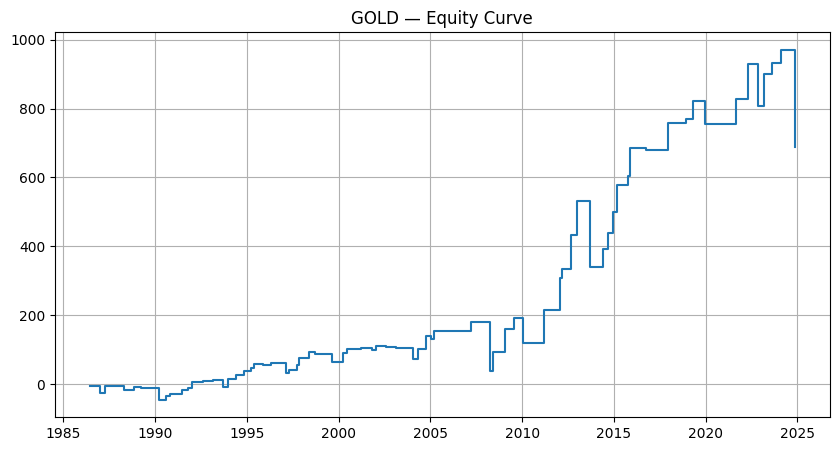

In [8]:
FUT = "gold"  # change to "es", "copper", etc.

path = dict(all_futures)[FUT]
df_f = load_future(path)
df_f = add_reversal_flags(df_f)

row = optimal_df[optimal_df["Future"] == FUT].iloc[0]
X, Y, Z, A, B, C = row[["X","Y","Z","A","B","C"]]

trades, metrics = run_strategy(df_f, X, Y, Z, A, B, C)

print(metrics)

trade_df = pd.DataFrame(trades)
trade_df["CumPnL"] = trade_df["PnL"].cumsum()

plt.figure(figsize=(10,5))
plt.step(trade_df["ExitTime"], trade_df["CumPnL"], where="post")
plt.title(f"{FUT.upper()} — Equity Curve")
plt.grid(True)
plt.show()
